### Import dataset/libraries

In [1]:
import numpy as np # import numpy
import pandas as pd # import pandas
import matplotlib.pyplot as plt # matplotlib
import nltk
import re
from nltk import pos_tag # for part-of-speech tagging
from nltk.stem import PorterStemmer,LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize, pos_tag, pos_tag_sents
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
nltk.download('stopwords')
stop = stopwords.words('english')

def tokenize(d):
    return word_tokenize(d)

def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Checked the head, info, and describe methods on created dataframe 'tweet'.

In [3]:
tweet = pd.read_csv("/kaggle/input/tweet-sentiments/test.csv")
train_df = pd.read_csv("/kaggle/input/tweet-sentiments/train.csv")

In [4]:
# Checking first 5 tweets

tweet.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [5]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [6]:
tweet.describe()

,textID,text,sentiment
count,3534,3534,3534
unique,3534,3534,3
top,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
freq,1,1,1430


### Pre-processing steps like Removing Punctuations, Numbers, and Special Characters, Stop Words in dataset.

In [7]:
# Function to clean the column

def basic_cleaning(text):
    """
    clear url/ not alpha/ fuck-bitch swear
    """
    text = re.sub(r'https?://www\.\S+\.cm', '', text)
    text = re.sub(r'[^a-zA-Z|\s]', '', text)
    text = re.sub(r'\*+', 'swear', text)
    return text

In [8]:
# Function to remove html tags

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

In [9]:
# Function to remove emoji from the text

def remove_emoji(text):
    #emoticons
    #symbols & pictographs
    #transport & map symbols
    #flags (iOS)
    emoji_pattern = re.compile("["\
        u"\U0001F600-\U0001F64F|"\
        u"\U0001F300-\U0001F5FF|"\
        u"\U0001F680-\U0001F6FF|"\
        u"\U0001F1E0-\U0001F1FF|"\
        u"\U00002702-\U000027B0|"\
        u"\U000024C2-\U0001F251"\
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [10]:
# remove repeated characters

def remove_multiplechars(text):
    """
    for example, so we have “way” instead of “waaaayyyyy”
    """
    text = re.sub(r'(.)\1{3,}', r'\1', text)
    return text


In [11]:
# Function calling all the above functions

def clean(msg):
    for col in ['text']:#,'selected_text']:
        msg[col] = msg[col].astype(str).apply(lambda x:basic_cleaning(x))
        msg[col] = msg[col].astype(str).apply(lambda x:remove_emoji(x))
        msg[col] = msg[col].astype(str).apply(lambda x:remove_html(x))
        msg[col] = msg[col].astype(str).apply(lambda x:remove_multiplechars(x))
    return msg.sample(frac=1)

In [12]:
# Cleaned_text

tweet_copy = tweet.copy()
cleaned_text = clean(tweet_copy)
cleaned_text_selection = cleaned_text.sample(frac=1)
X = cleaned_text_selection.text.values
y, uniques = pd.factorize(cleaned_text_selection.sentiment, sort=True)
y_tf = pd.get_dummies(cleaned_text_selection.sentiment)
print('clean Done')
tweet

clean Done


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive
...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative
3530,416863ce47,All alone in this old house again. Thanks for...,positive
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive


<AxesSubplot:ylabel='sentiment'>

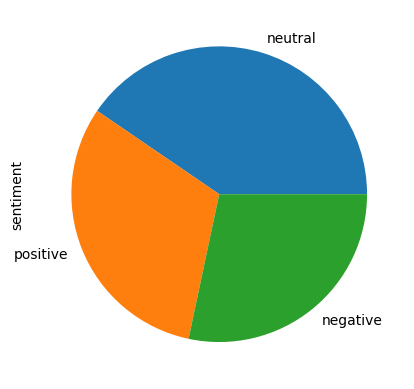

In [13]:
# Sentiment plotted in pie chart

cleaned_text_selection.sentiment.value_counts().plot.pie()

Normalize review by using Stemming or Lemmatization

In [14]:
# Stemming

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def word_stemmer(text):
    stem_text = " ".join([stemmer.stem(i) for i in text])
    return stem_text

cleaned_text_selection['text'] = cleaned_text_selection['text'].apply(lambda x: word_stemmer(x))
cleaned_text.head(20)

,textID,text,sentiment
1885,839095ea38,httptwitpiccomnbd Ready for our D Jonas Broth...,neutral
1557,ea5c577cb7,lol exams i didnt go to mcast or other school...,negative
1003,bd499c0bf7,Succesfully following Tayla,positive
248,5a91b175f6,goodnight,positive
734,63ec4e7de6,hey You abandoned me here on Twitter momma dots,neutral
2186,0ac7e72578,Biology final today Then home to prepare for p...,neutral
2541,d50b0a5b94,haha I know Sorry about all the typos in tha...,positive
801,434e673353,home for the nite sleeping on the pull out bed...,neutral
2747,d18a55e49e,alice doesnt know what to wear to the cinema,negative
630,faaf6a6f64,I dont even look at their fabric unless I nee...,neutral


Preprocessed text should be included in the tweet data frame as cleaned_text. Plot word cloud for all classes the tweets

In [15]:
# Sample of cleaned text

tweet['cleaned_text'] = cleaned_text['text']
tweet.head(20)

,textID,text,sentiment,cleaned_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day httptwitpiccomezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,Shanghai is also really exciting precisely s...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,Recession hit Veronique Branquinho she has to ...
3,01082688c6,happy bday!,positive,happy bday
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,httptwitpiccomwp I like it
5,726e501993,that`s great!! weee!! visitors!,positive,thats great weee visitors
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol,negative,I THINK EVERYONE HATES ME ON HERE lol
7,afa11da83f,"soooooo wish i could, but im in school and my...",negative,so wish i could but im in school and myspace ...
8,e64208b4ef,and within a short time of the last clue all ...,neutral,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...,neutral,What did you get My day is alright havent do...


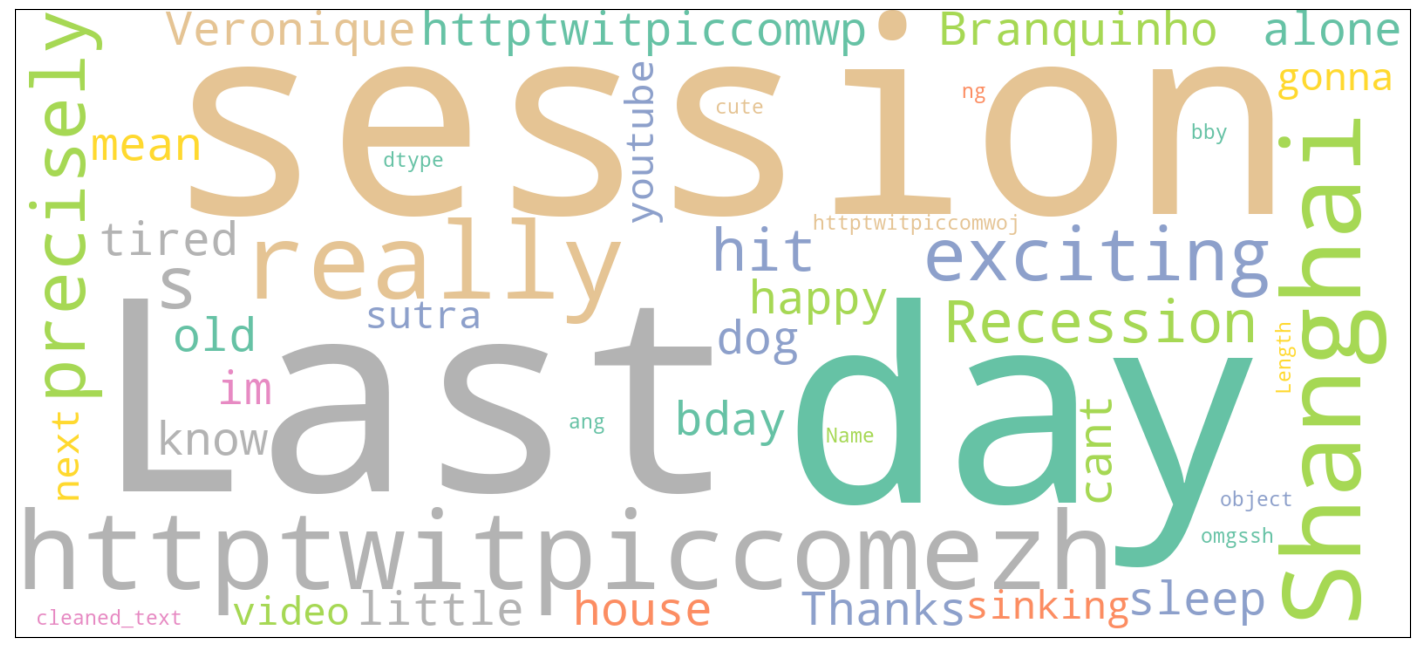

In [16]:
# Wordcloud for entire dataframe

plt.figure(figsize=(18,15))
wc = WordCloud(min_font_size=3,max_words=1000,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(str(tweet['cleaned_text']))
plt.imshow(wc,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

In [17]:
# Wordcloud for each dataframe

positive = tweet[tweet.sentiment == 'positive'].text.apply(clean_text).apply(tokenize)
positive = [" ".join(positive.values[i]) for i in range(len(positive))]
positive = [" ".join(positive)][0]

negative = tweet[tweet.sentiment == 'negative'].text.apply(clean_text).apply(tokenize)
negative = [" ".join(negative.values[i]) for i in range(len(negative))]
negative = [" ".join(negative)][0]

neutral = tweet[tweet.sentiment == 'neutral'].text.apply(clean_text).apply(tokenize)
neutral = [" ".join(neutral.values[i]) for i in range(len(neutral))]
neutral = [" ".join(neutral)][0]

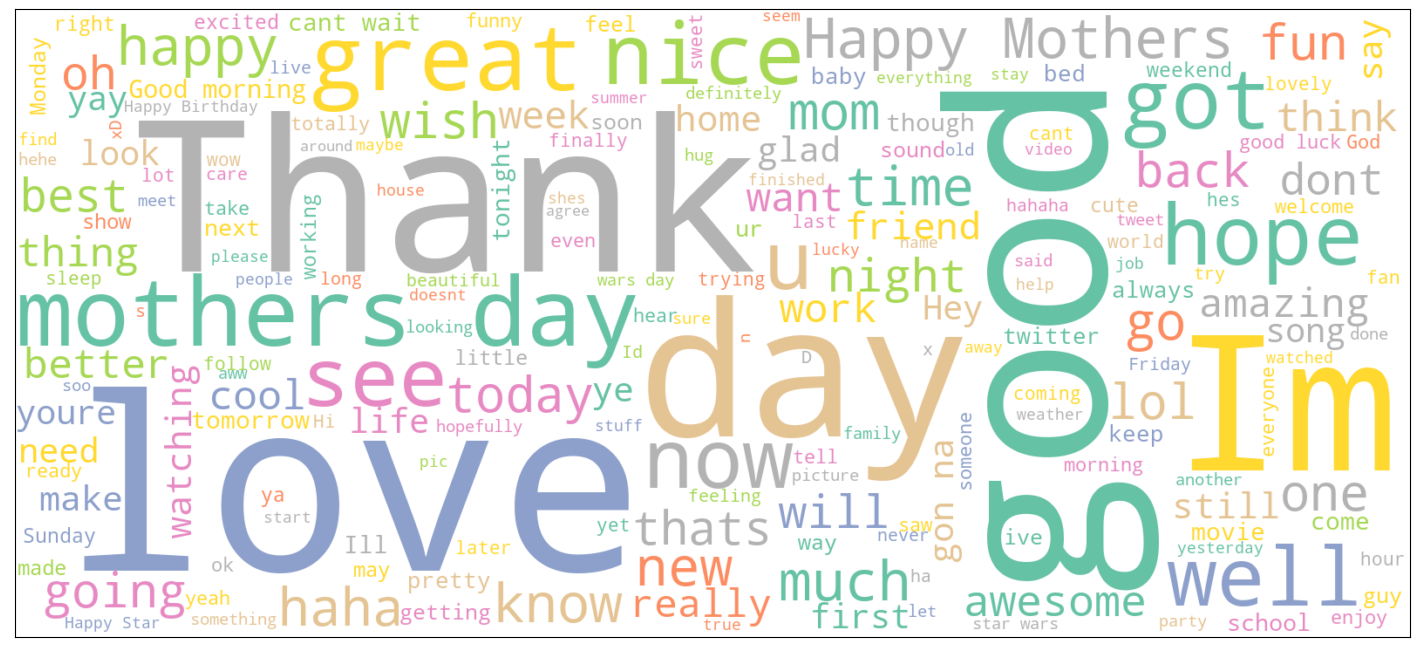

In [18]:
# Wordcloud for positive reviews

plt.figure(figsize=(18,15))
wc_positive = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(positive)

plt.imshow(wc_positive,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

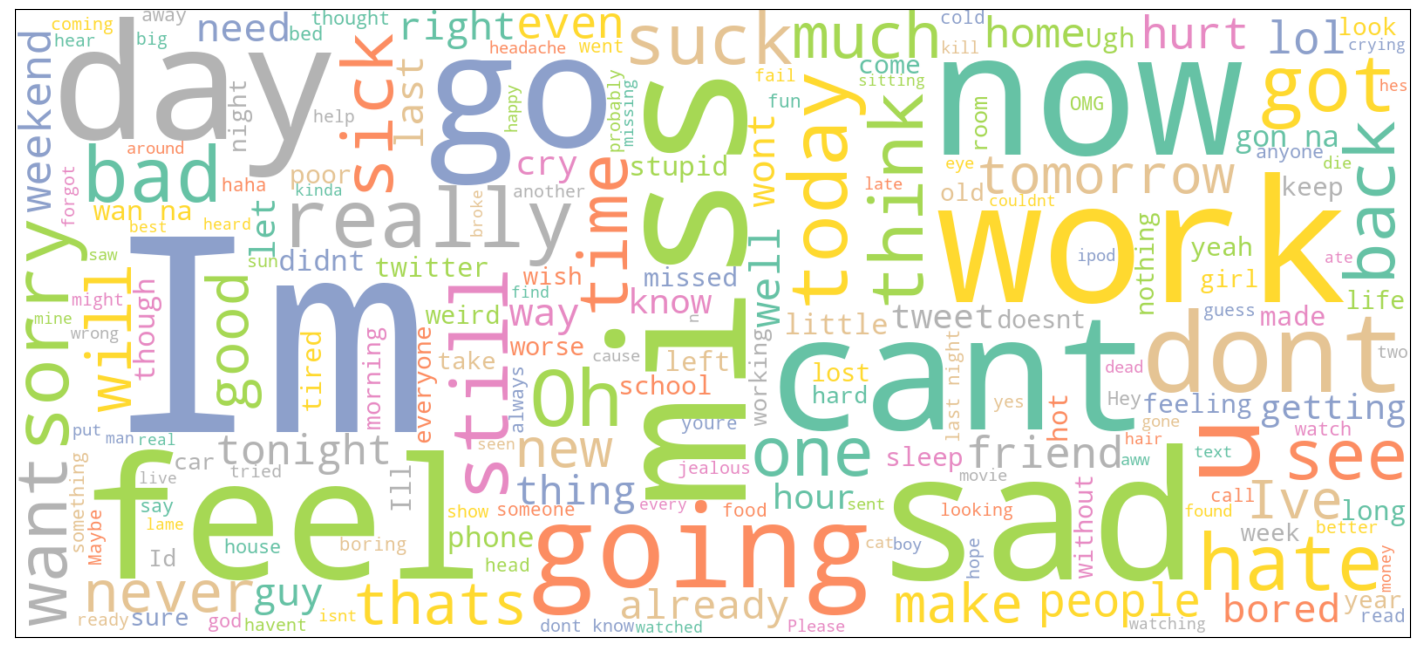

In [19]:
# Wordcloud for negative reviews

plt.figure(figsize=(18,15))
wc_negative = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(negative)

plt.imshow(wc_negative,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

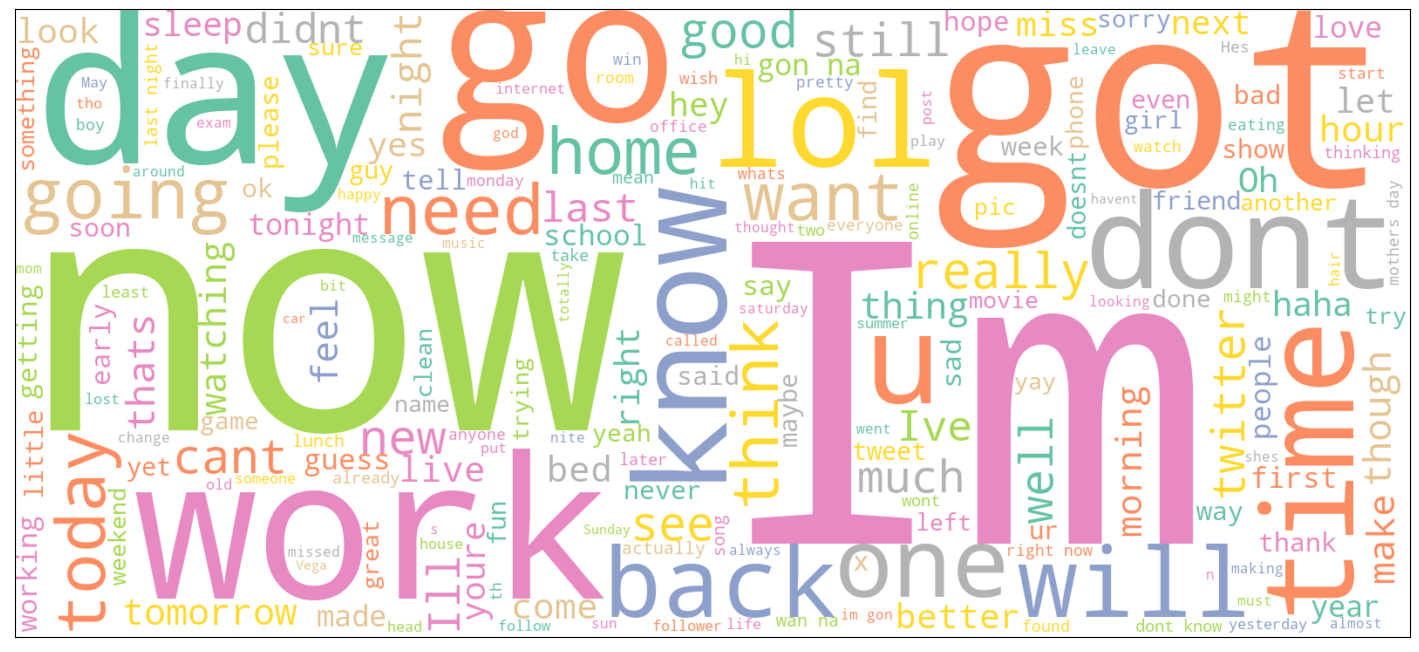

In [20]:
# Wordcloud for neutral reviews

plt.figure(figsize=(18,15))
wc_neutral = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(neutral)

plt.imshow(wc_neutral,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

In [21]:
# Function to convert sentiment into a numeric value

def convert_Sentiment(sentiment):
    if  sentiment == "positive":
        return 2
    elif sentiment == "neutral":
        return 1
    elif sentiment == "negative":
        return 0
    
tweet['converted_sentiment'] = tweet.sentiment.apply(lambda x : convert_Sentiment(x))

#### Created two objects X and y. X will be the 'cleaned_text ' column of tweet data frame and y will be the ' Sentiment' column.

In [22]:
x = tweet['cleaned_text']
y = tweet['converted_sentiment']
x.sample(5)

1028        i wanna see the rest i only saw like  minutes
3335                   Last time well get tacos like this
523                                 Hey Esmee How U doing
2307    I want it to be summer NOW why is it sprinklin...
2019     knackered been awake since  as couldnt sleep ...
Name: cleaned_text, dtype: object

In [23]:
y.sample(5)

339     1
3015    2
1662    0
2779    1
1405    0
Name: converted_sentiment, dtype: int64

### A Word2Vec object is created. The data is split into training and testing sets.

In [24]:
tweet['tokenized_sents'] = tweet.apply(lambda row: nltk.word_tokenize(row['cleaned_text']), axis=1)
X = tweet.cleaned_text
y = tweet.converted_sentiment

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
# Setting sg = 1 for Word2Vec 

texts_w2v = tweet.tokenized_sents.to_list()
w2v = Word2Vec(sentences = texts_w2v, window = 3, vector_size = 100, min_count = 5, workers = 4, sg = 1)

In [26]:
def get_avg_vector(sent):
    vector = np.zeros(100)
    total_words = 0
    for word in sent.split():        
        if word in w2v.wv.key_to_index:    
            vector += w2v.wv.word_vec(word)
            total_words += 1
    if total_words > 0:
        return vector / total_words
    else:
        return vector
    
tweet['w2v_vector'] = tweet['cleaned_text'].map(get_avg_vector)
tweet[['cleaned_text', 'w2v_vector']].head(2)

,cleaned_text,w2v_vector
0,Last session of the day httptwitpiccomezh,"[-0.06840020511299372, 0.14595706574618816, 0...."
1,Shanghai is also really exciting precisely s...,"[-0.0684653062905584, 0.1469867846795491, 0.01..."


### Logistic regression

In [27]:
# Logistic regression and confusion matrix

model_params = {'random_state':42}
model_list = [LogisticRegression(**model_params, solver='liblinear')]
model_name = ['LogisticRegression']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list, model_name):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(tweet.index, tweet.converted_sentiment)):        
        X_trn = np.stack(tweet.loc[trn_idx, 'w2v_vector'])
        y_trn = tweet.loc[trn_idx, 'converted_sentiment']
        
        X_vld = np.stack(tweet.loc[vld_idx, 'w2v_vector'])
        y_vld = tweet.loc[vld_idx, 'converted_sentiment']        
        
        model.fit(X_trn, y_trn)
        pred_col = f"{model_name}_w2v_pred"
        tweet.loc[vld_idx, pred_col] = model.predict(X_vld)
        modelTrain = model.predict(X_trn)
        modelTest = model.predict(X_vld)

    

### Decision tree model trained.

In [28]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()

In [29]:
# DecisionTreeClassifier and confusion matrix 

classifier = DecisionTreeClassifier()
classifier.fit(X_trn, y_trn)
y_pred = classifier.predict(X_vld)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_vld, y_pred))
print(classification_report(y_vld, y_pred))

[[ 65  82  53]
 [ 76 125  85]
 [ 57  84  79]]
              precision    recall  f1-score   support

           0       0.33      0.33      0.33       200
           1       0.43      0.44      0.43       286
           2       0.36      0.36      0.36       220

    accuracy                           0.38       706
   macro avg       0.37      0.37      0.37       706
weighted avg       0.38      0.38      0.38       706



### CBow object is created and the data is split into training and testing sets.

In [30]:
# Setting sg = 0 for CBOW 

w2v = Word2Vec(sentences = texts_w2v, window = 3, vector_size = 100, min_count = 5, workers = 4, sg = 0)

### Logistic Regression and decision tree models are trained.

In [31]:
# DecisionTreeClassifier and confusion matrix

classifier = DecisionTreeClassifier()
classifier.fit(X_trn, y_trn)
y_pred = classifier.predict(X_vld)
y_trainset = classifier.predict(X_trn)
from sklearn.metrics import classification_report, confusion_matrix

# Confusion matrix for test set

print(confusion_matrix(y_vld, y_pred))
print(classification_report(y_vld, y_pred))

[[ 63  76  61]
 [ 71 125  90]
 [ 52  86  82]]
              precision    recall  f1-score   support

           0       0.34      0.32      0.33       200
           1       0.44      0.44      0.44       286
           2       0.35      0.37      0.36       220

    accuracy                           0.38       706
   macro avg       0.38      0.37      0.37       706
weighted avg       0.38      0.38      0.38       706



In [32]:
# Confusion matrix for train set

print(confusion_matrix(y_trn, y_trainset))
print(classification_report(y_trn, y_trainset))

[[ 795    6    0]
 [   2 1142    0]
 [   0   10  873]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       801
           1       0.99      1.00      0.99      1144
           2       1.00      0.99      0.99       883

    accuracy                           0.99      2828
   macro avg       0.99      0.99      0.99      2828
weighted avg       0.99      0.99      0.99      2828



In [33]:
# Logistic regression and confusion matrix

model_params = {'random_state':42}
model_list = [LogisticRegression(**model_params, solver='liblinear')]
model_name = ['LogisticRegression']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list, model_name):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(tweet.index, tweet.converted_sentiment)):        
        X_trn = np.stack(tweet.loc[trn_idx, 'w2v_vector'])
        y_trn = tweet.loc[trn_idx, 'converted_sentiment']
        
        X_vld = np.stack(tweet.loc[vld_idx, 'w2v_vector'])
        y_vld = tweet.loc[vld_idx, 'converted_sentiment']        
        
        model.fit(X_trn, y_trn)
        pred_col = f"{model_name}_w2v_pred"
        tweet.loc[vld_idx, pred_col] = model.predict(X_vld)
        modelTrain = model.predict(X_trn)
        modelTest = model.predict(X_vld)

# Confusion matrix for test set

print(confusion_matrix(y_vld, modelTest))  

# Confusion matrix for test set

print(confusion_matrix(y_trn, modelTrain))  

[[  0 200   0]
 [  0 286   0]
 [  0 220   0]]
[[   0  801    0]
 [   0 1144    0]
 [   0  882    1]]


### Display the HMM POS tagging on the first 4 rows of ‘cleaned_text’.

In [34]:
# Selected first 4 rows of tweet dataframe

selected_tweet = tweet.head(4)
texts = selected_tweet['cleaned_text'].tolist()
texts

['Last session of the day  httptwitpiccomezh',
 ' Shanghai is also really exciting precisely  skyscrapers galore Good tweeps in China  SH  BJ',
 'Recession hit Veronique Branquinho she has to quit her company such a shame',
 ' happy bday']

In [35]:
# POS tagging

nltk.download('averaged_perceptron_tagger')
tagged_texts = pos_tag_sents(map(word_tokenize, texts))
tagged_texts

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[[('Last', 'JJ'),
  ('session', 'NN'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('day', 'NN'),
  ('httptwitpiccomezh', 'VB')],
 [('Shanghai', 'NNP'),
  ('is', 'VBZ'),
  ('also', 'RB'),
  ('really', 'RB'),
  ('exciting', 'VBG'),
  ('precisely', 'RB'),
  ('skyscrapers', 'NNS'),
  ('galore', 'RB'),
  ('Good', 'JJ'),
  ('tweeps', 'NNS'),
  ('in', 'IN'),
  ('China', 'NNP'),
  ('SH', 'NNP'),
  ('BJ', 'NNP')],
 [('Recession', 'NN'),
  ('hit', 'VBD'),
  ('Veronique', 'NNP'),
  ('Branquinho', 'NNP'),
  ('she', 'PRP'),
  ('has', 'VBZ'),
  ('to', 'TO'),
  ('quit', 'VB'),
  ('her', 'PRP$'),
  ('company', 'NN'),
  ('such', 'PDT'),
  ('a', 'DT'),
  ('shame', 'NN')],
 [('happy', 'JJ'), ('bday', 'NN')]]